In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [3]:
cuml_umap = cumlUMAP()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [4]:
import numpy as np
import pandas as pd
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [5]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms#

In [6]:
from avgn.visualization.projections import scatter_spec, scatter_projections
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

In [7]:
import hdbscan

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [8]:
DATASET_ID = 'swamp_sparrow'

In [9]:
syllable_df = pd.read_pickle(DATA_DIR / 'syllable_dfs' / DATASET_ID / 'swampsparrow-taper_with_freq2.pickle')

In [10]:
syllable_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1705    0.2145       0.0              0.0     6158.496094   
1      0.2035    0.2550       0.0              1.0     3746.777344   
2      0.2625    0.2910       0.0              2.0     8311.816406   

   peakfreq_end       indv  indvi              POPID      GRIDX        GRIDY  \
0   5254.101562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
1   4048.242188  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
2   3875.976562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   

             key                                              audio   rate  \
0  SWSP09TIV18L1  [0.0, 0.0005278791589983579, 0.001123593156707...  44100   
1  SWSP09TIV18L1  [0.0, -0.015641441632961404, -0.04495665944855...  44100   
2  SWSP09TIV18L1  [-0.0, -0.001130732482877271, -0.0025247620611...  44100   

   syll_len      f_start        f_end  \
0  0.043991  5857.031250  6287.695312   
1  0.051497  5469.433594  4220.507812   
2  0.028503  7795.019531  3919.042969   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [11]:
len(syllable_df.indv.unique())

615

In [12]:
### get population info

In [15]:
pd.DataFrame({
    i: [np.sum(syllable_df['POPID'].values == i)]
    for i in np.unique(syllable_df['POPID'].values)
}).T.sort_values(
    by=0, ascending=False)

0
Conneaut, PA       31938
Hudson Valley, NY  15527
Horicon, WI        14825
Adirondacks, NY    13007
Waterloo, MI       12110
Montezuma, NY      10091

In [16]:
specs = np.stack(syllable_df['spectrogram'].values)
#embedding = np.vstack(syllable_df['umap_0.5'].values)

In [17]:
syllable_df['f_diff_est'] = syllable_df['f_start'].values - syllable_df['f_end'].values

In [18]:
syllable_df['f_diff'] = syllable_df['peakfreq_start'].values - syllable_df['peakfreq_end'].values

In [19]:
syllable_df['syll_len'] = syllable_df['syll_len']*1000

In [20]:
syllable_df['syll_len'][:5]

0    43.990930
1    51.496599
2    28.503401
3    49.501134
4    55.510204
Name: syll_len, dtype: float64

In [21]:
embedding_freq = np.vstack([
    syllable_df['peakfreq_start'].values,
    syllable_df['peakfreq_end'].values,
]).T

In [72]:
embedding = np.vstack([
    syllable_df['syll_len']+ np.random.rand(len(syllable_df['syll_len'])),
    syllable_df['f_diff'].values #+ np.random.rand(len(syllable_df['f_diff'])),
]).T
embedding[:,0] = np.log(embedding[:,0])

(-5000, 10000)

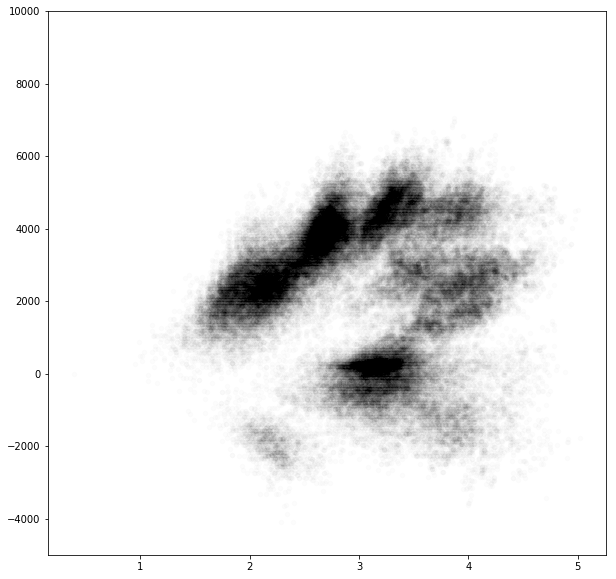

In [73]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(embedding[:,0],embedding[:,1],  alpha = 0.01, s=20, color='k')
#ax.set_xlim([1, 1000])
ax.set_ylim([-5000, 10000])
#ax.set_xscale('log')

In [74]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': syllable_df.POPID.values[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

IndexError: boolean index did not match indexed array along dimension 0; dimension is 15526 but corresponding boolean dimension is 97497

<Figure size 720x720 with 0 Axes>

### UMAP for a single community

In [76]:
POPID = 'Conneaut, PA'

In [25]:
subset_df = syllable_df[syllable_df.POPID == POPID]

In [26]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(31938, 704)

In [27]:
cuml_umap = cumlUMAP()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [28]:
umap_embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [29]:
embedding = np.vstack([
    np.log(subset_df['syll_len'] + np.random.rand(len(subset_df['syll_len']))),
    subset_df['f_diff'].values #+ np.random.rand(len(subset_df['f_diff'])),
]).T

In [30]:
pos = subset_df['pos_in_syllable'].values[:nex]
pos[pos>7 ]= 8

In [31]:
len(pos)

31937

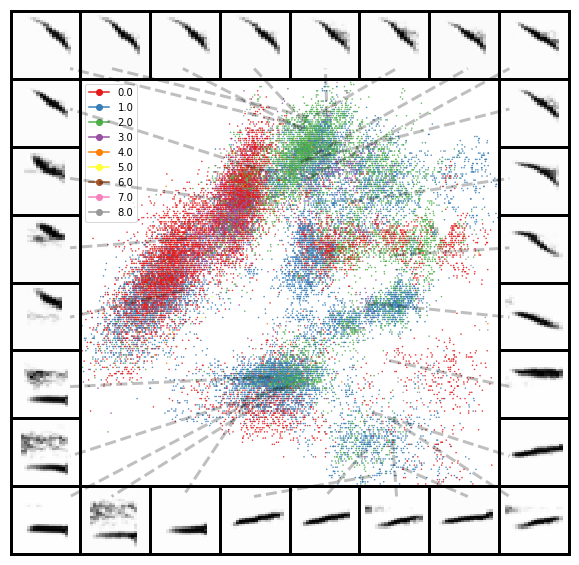

In [32]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'len_fchange_pos', dpi=300, save_jpg=True, save_png=True)

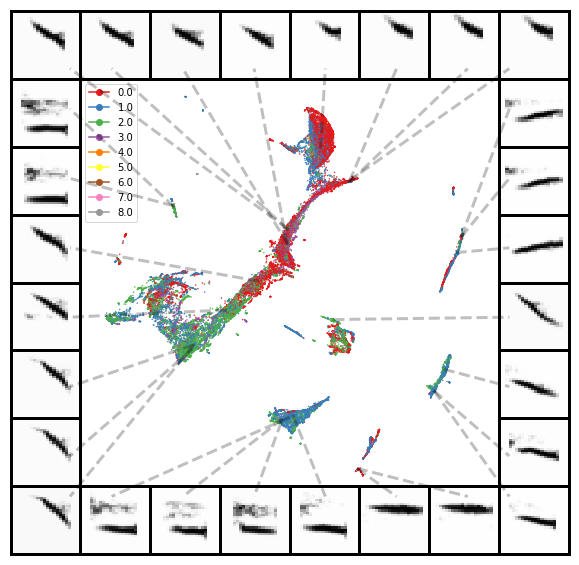

In [33]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'umap_pos', dpi=300, save_jpg=True, save_png=True)

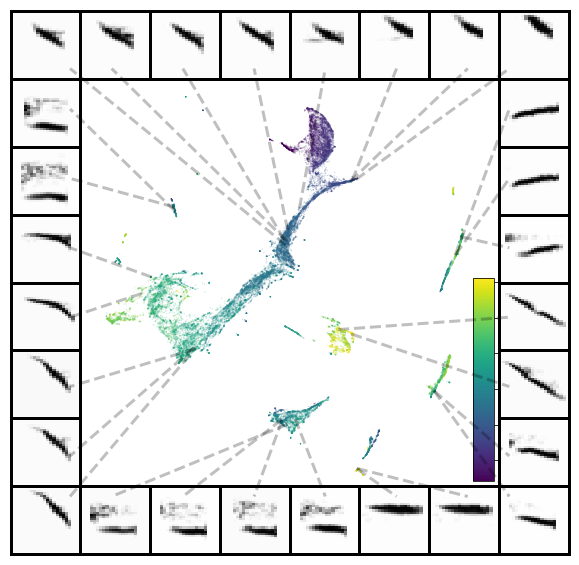

In [34]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': np.log(subset_df['syll_len'].values[:nex]), #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'umap_syll_len', dpi=300, save_jpg=True, save_png=True)

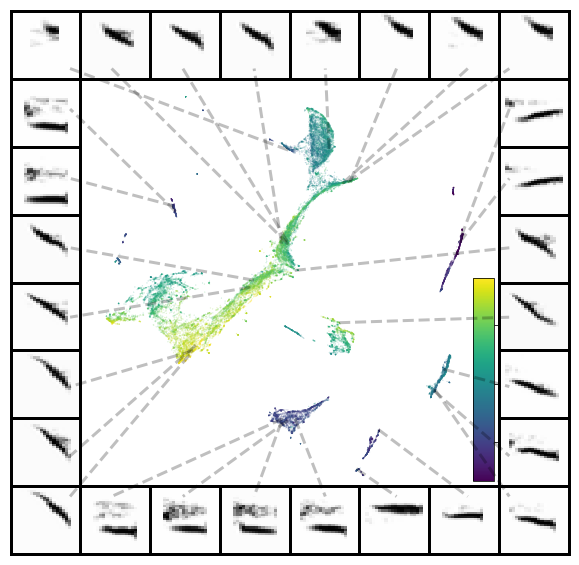

In [35]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'umap_f_diff', dpi=300, save_jpg=True, save_png=True)

In [36]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(umap_embedding) * 0.01), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(umap_embedding);
#clusterer.labels_

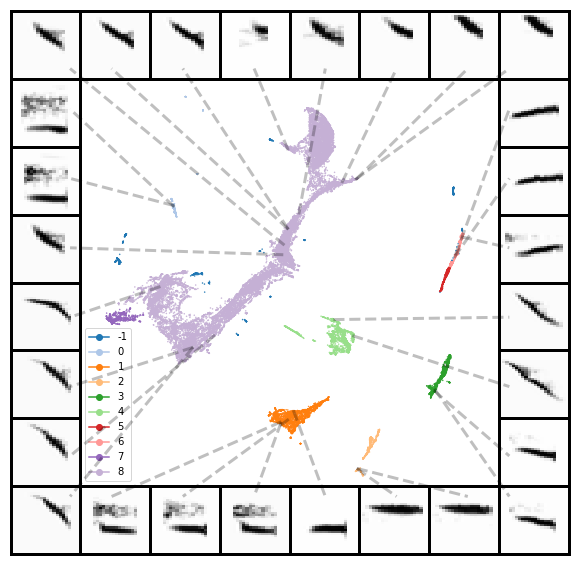

In [37]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'umap_cluster', dpi=300, save_jpg=True, save_png=True)

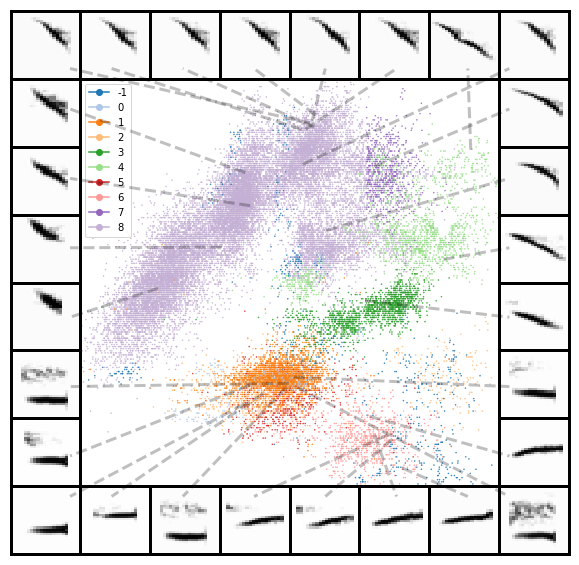

In [38]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
ensure_dir(figs_loc)
save_fig( figs_loc/ 'len_fchange_cluster', dpi=300, save_jpg=True, save_png=True)

In [39]:
embedding_freq = np.vstack([
    subset_df['peakfreq_start'].values+ np.random.rand(len(subset_df['peakfreq_start']))*100,
    subset_df['peakfreq_end'].values+ np.random.rand(len(subset_df['peakfreq_end']))*100,
]).T

In [78]:
nex = -1
scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
save_fig( figs_loc/ 'fstart_fend_pos', dpi=300, save_jpg=True, save_png=True)

'Conneaut_PA'

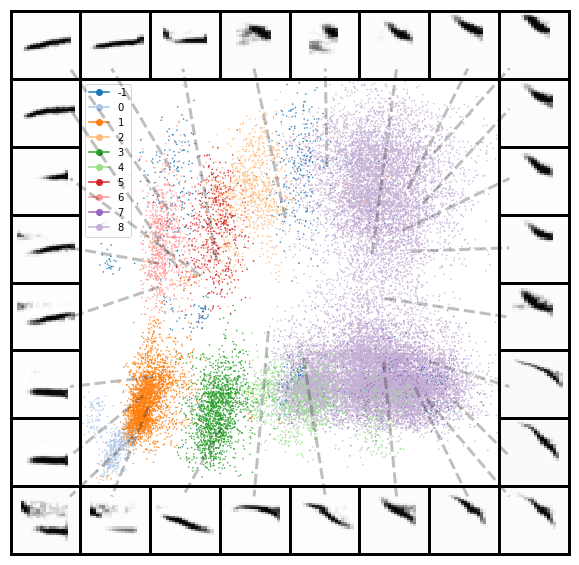

In [41]:
nex = -1
scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
figs_loc = FIGURE_DIR / 'discrete_umap' / 'swamp_sparrow_community' / POPID.replace(', ', '_')
save_fig( figs_loc/ 'fstart_fend_cluster', dpi=300, save_jpg=True, save_png=True)

In [42]:
subset_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1470    0.1540       0.0              0.0     6244.628906   
1      0.1485    0.1710       0.0              1.0     3273.046875   
2      0.1825    0.2095       0.0              2.0     7924.218750   

   peakfreq_end           indv  indvi         POPID      GRIDX        GRIDY  \
0   4866.503906  PAGeneva08-57      0  Conneaut, PA  41.587287  -80.2368289   
1   3057.714844  PAGeneva08-57      0  Conneaut, PA  41.587287  -80.2368289   
2   3359.179688  PAGeneva08-57      0  Conneaut, PA  41.587287  -80.2368289   

                 key                                              audio  \
0  PymGeneva08T57C-W  [-0.0, -0.0041904511122867975, -0.004001130574...   
1  PymGeneva08T57C-W  [0.0, 0.0009144610115166368, 0.003067977726459...   
2  PymGeneva08T57C-W  [-0.0, -0.0002621038784754687, -0.000141924985...   

    rate   syll_len      f_start        f_end  \
0  44100   7.006803  2971.582031  3488.378906   
1  44100  22.517007  4909.570312  3014.648438   
2  44100  26.984127  7838.085938  3832.910156   

                                         spectrogram   f_diff_est       f_diff  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  -516.796875  1378.125000  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1894.921875   215.332031  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  4005.175781  4565.039062

Text(0.5, 1.0, 'freq_diff')

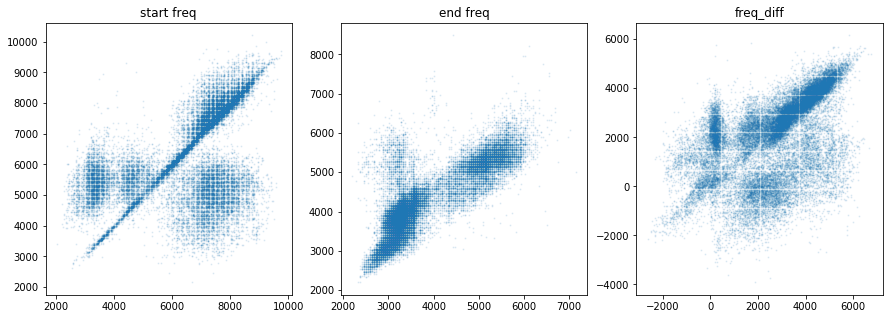

In [43]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].scatter(subset_df.peakfreq_start, subset_df.f_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.peakfreq_end, subset_df.f_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[2].scatter(subset_df.f_diff, subset_df.f_diff_est, s=1, alpha = 0.1)
axs[2].set_title('freq_diff')

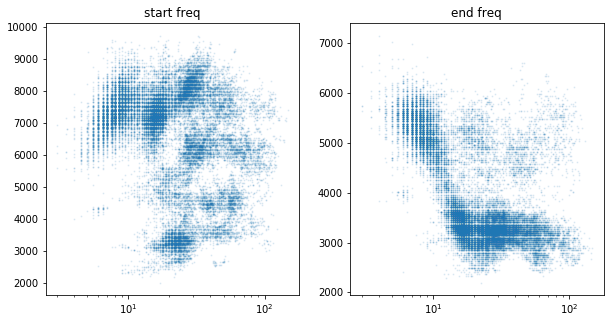

In [44]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].scatter(subset_df.syll_len, subset_df.peakfreq_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.syll_len, subset_df.peakfreq_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[0].set_xscale('log')
axs[1].set_xscale('log')

#### plot spectrograms from categories

In [45]:
from avgn.visualization.spectrogram import draw_spec_set

In [46]:
unique_clusters = np.unique(clusterer.labels_)[1:]
len(unique_clusters)

9

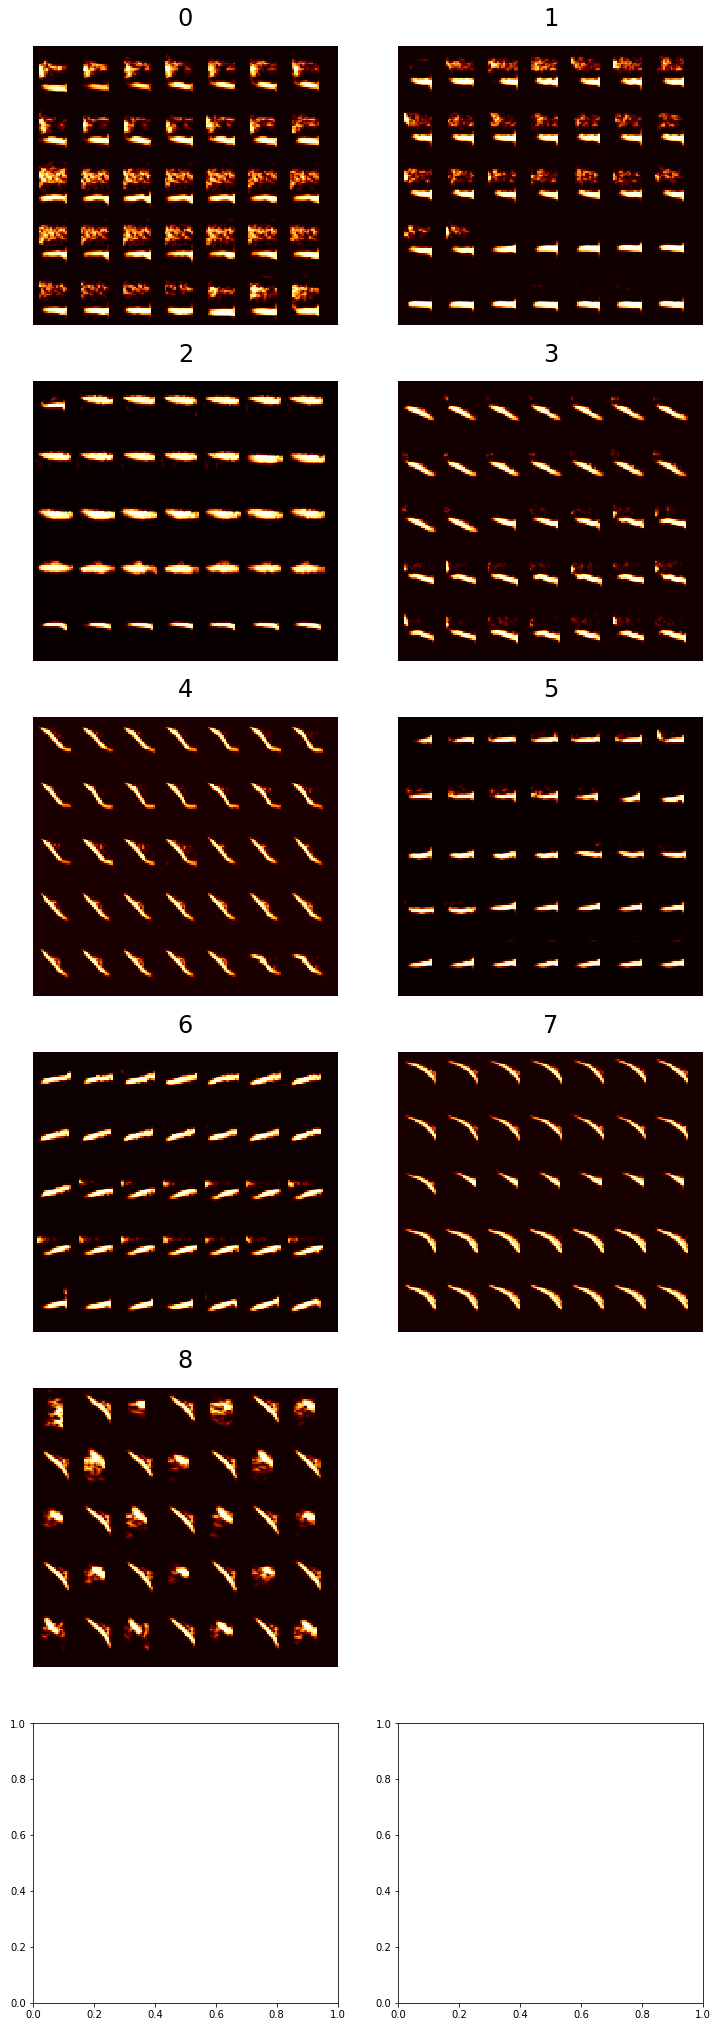

In [47]:
zm = 6
ncols=6
nrows=int(np.ceil(len(unique_clusters)/ncols))

fig, axs = plt.subplots(nrows=nrows, ncols =ncols, figsize= (ncols*zm, nrows*zm))
for li, label in enumerate(unique_clusters):
    ax = axs.flatten()[li]
    draw_spec_set(np.array(specs)[clusterer.labels_ == label], zoom=1, maxrows=5, colsize=5, ax=ax)
    ax.set_title(label, fontsize=24)
for li in range(li, len(unique_clusters)+1):
    ax = axs.flatten()[li]
    ax.axis('off')
plt.show();

### UMAP for a single community

In [ ]:
POPID = 'Hudson Valley, NY'

In [48]:
subset_df = syllable_df[syllable_df.POPID == POPID]

In [49]:
specs = list(subset_df.spectrogram.values)
specs = [i/np.max(i) for i in tqdm(specs)]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(15527, 704)

In [50]:
cuml_umap = cumlUMAP()

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [51]:
umap_embedding = cuml_umap.fit_transform(specs_flattened)

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Parameter should_downcast is deprecated, use convert_dtype in fit, fit_transform and transform  methods instead. 
  """Entry point for launching an IPython kernel.


In [52]:
embedding = np.vstack([
    np.log(subset_df['syll_len'] + np.random.rand(len(subset_df['syll_len']))),
    subset_df['f_diff'].values #+ np.random.rand(len(subset_df['f_diff'])),
]).T

In [53]:
pos = subset_df['pos_in_syllable'].values[:nex]
pos[pos>7 ]= 8

In [54]:
len(pos)

15526

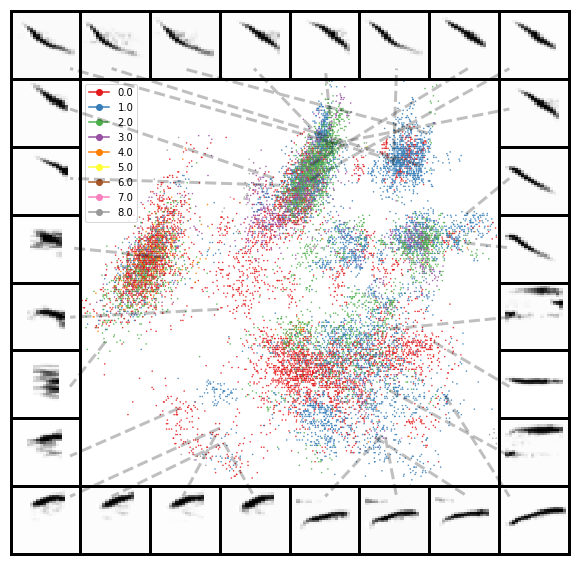

In [55]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

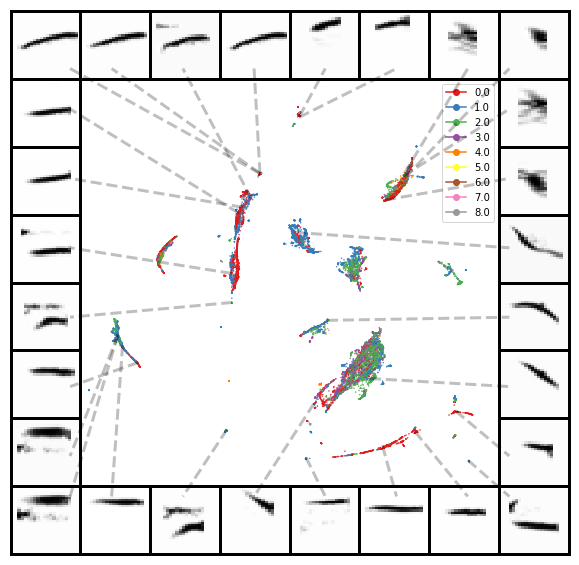

In [56]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

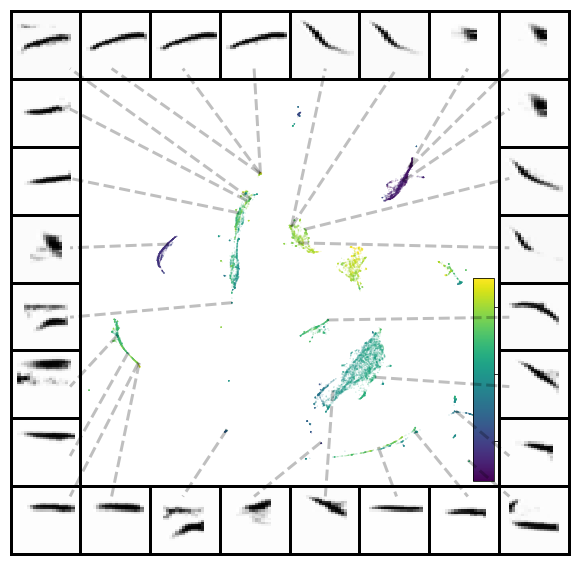

In [57]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': np.log(subset_df['syll_len'].values[:nex]), #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

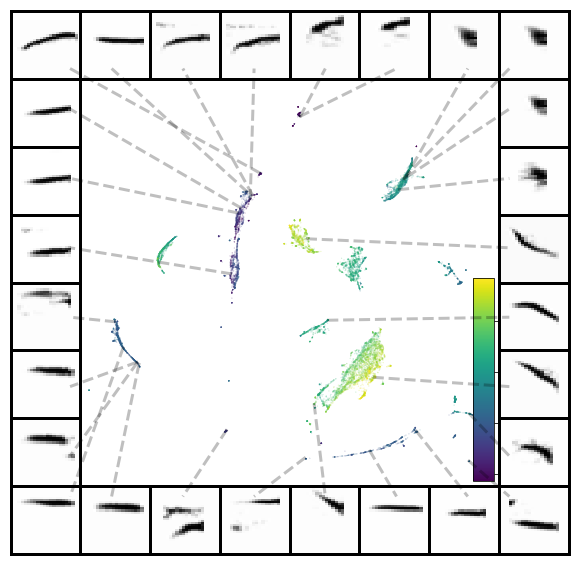

In [58]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': subset_df['f_diff'].values[:nex], #syllable_df.labels.values[:nex],
        'categorical_labels': False,
        'color_palette': plt.cm.viridis,
        'alpha':1,
        's': 0.01,
        'show_legend': True
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

In [59]:
clusterer = hdbscan.HDBSCAN(
    min_cluster_size=int(len(umap_embedding) * 0.01), # the smallest size we would expect a cluster to be
    min_samples=1, # larger values = more conservative clustering
)
clusterer.fit(umap_embedding);
#clusterer.labels_

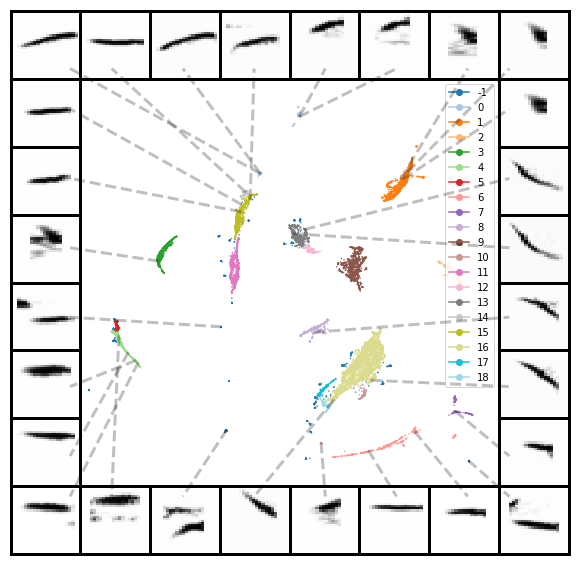

In [60]:
nex = -1
scatter_spec(
    umap_embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

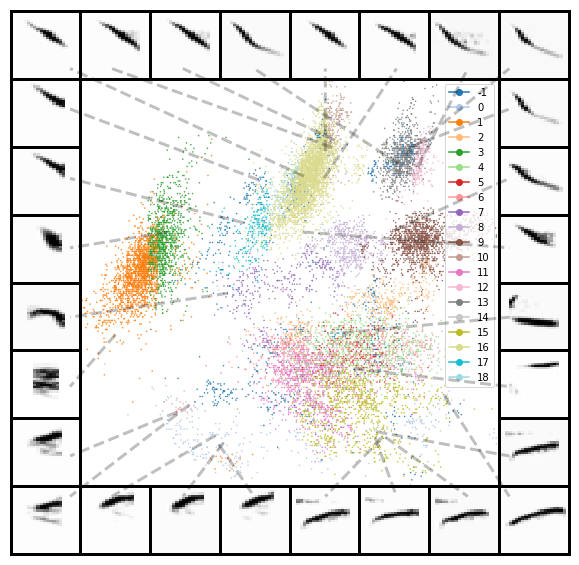

In [61]:
nex = -1
scatter_spec(
    embedding[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

In [62]:
embedding_freq = np.vstack([
    subset_df['peakfreq_start'].values+ np.random.rand(len(subset_df['peakfreq_start']))*100,
    subset_df['peakfreq_end'].values+ np.random.rand(len(subset_df['peakfreq_end']))*100,
]).T

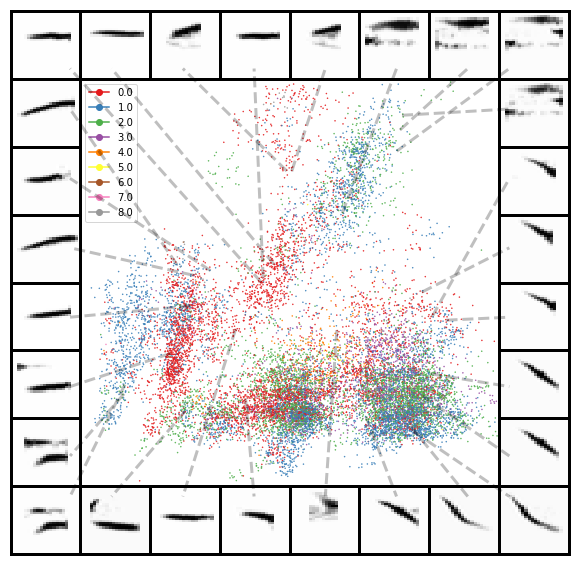

In [63]:
nex = -1
scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': pos,
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

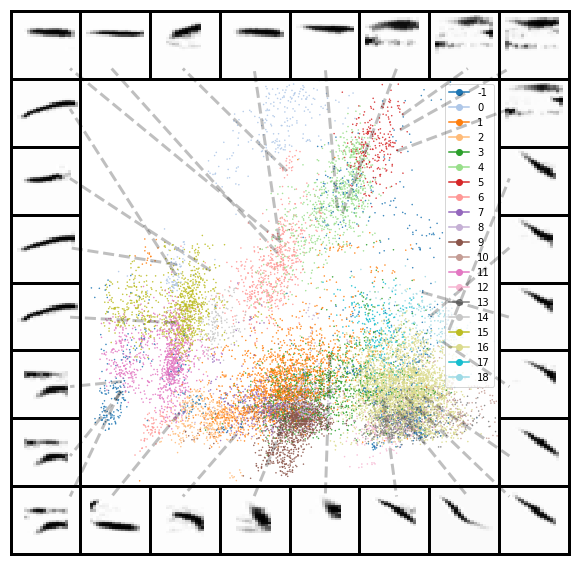

In [64]:
nex = -1
scatter_spec(
    embedding_freq[:nex],
    specs[:nex],
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.1,
    scatter_kwargs = {
        'labels': clusterer.labels_[:nex],
        'alpha':1,
        's': 0.25,
        'show_legend': True,
        'log_x':False,
        'color_palette': 'tab20',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'swamp-sparrow-taper', dpi=300, save_jpg=True, save_png=True)

In [65]:
subset_df[:3]

start_time  end_time  syllable  pos_in_syllable  peakfreq_start  \
0      0.1705    0.2145       0.0              0.0     6158.496094   
1      0.2035    0.2550       0.0              1.0     3746.777344   
2      0.2625    0.2910       0.0              2.0     8311.816406   

   peakfreq_end       indv  indvi              POPID      GRIDX        GRIDY  \
0   5254.101562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
1   4048.242188  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   
2   3875.976562  NYHVTIV18      0  Hudson Valley, NY  42.042489  -73.9237463   

             key                                              audio   rate  \
0  SWSP09TIV18L1  [0.0, 0.0005278791589983579, 0.001123593156707...  44100   
1  SWSP09TIV18L1  [0.0, -0.015641441632961404, -0.04495665944855...  44100   
2  SWSP09TIV18L1  [-0.0, -0.001130732482877271, -0.0025247620611...  44100   

    syll_len      f_start        f_end  \
0  43.990930  5857.031250  6287.695312   
1  51.496599  5469.433594  4220.507812   
2  28.503401  7795.019531  3919.042969   

                                         spectrogram   f_diff_est       f_diff  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  -430.664062   904.394531  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  1248.925781  -301.464844  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  3875.976562  4435.839844

Text(0.5, 1.0, 'freq_diff')

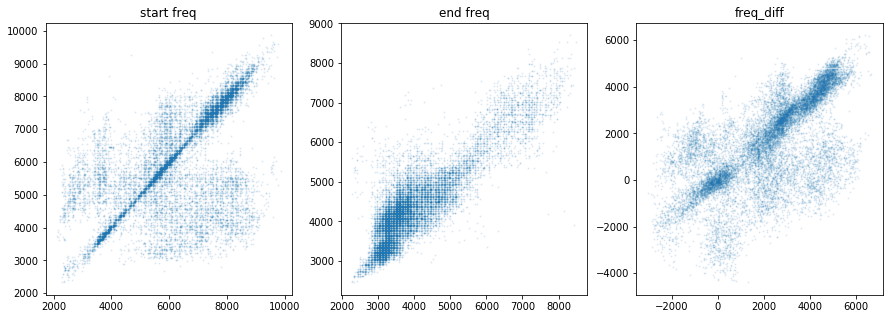

In [66]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=3, figsize=(15,5))
axs[0].scatter(subset_df.peakfreq_start, subset_df.f_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.peakfreq_end, subset_df.f_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[2].scatter(subset_df.f_diff, subset_df.f_diff_est, s=1, alpha = 0.1)
axs[2].set_title('freq_diff')

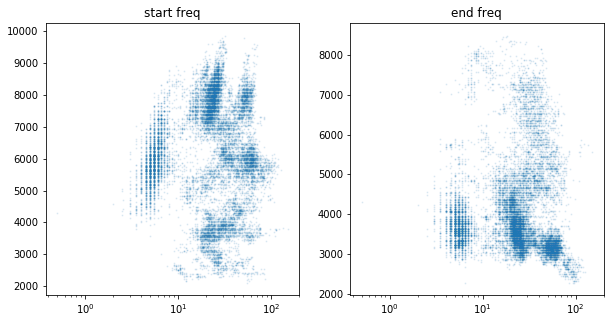

In [67]:
# compare estimated to dataset
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
axs[0].scatter(subset_df.syll_len, subset_df.peakfreq_start, s=1, alpha = 0.1)
axs[0].set_title('start freq')
axs[1].scatter(subset_df.syll_len, subset_df.peakfreq_end, s=1, alpha = 0.1)
axs[1].set_title('end freq')
axs[0].set_xscale('log')
axs[1].set_xscale('log')

#### plot spectrograms from categories

In [68]:
from avgn.visualization.spectrogram import draw_spec_set

In [69]:
unique_clusters = np.unique(clusterer.labels_)[1:]
len(unique_clusters)

19

IndexError: index 12 is out of bounds for axis 0 with size 12

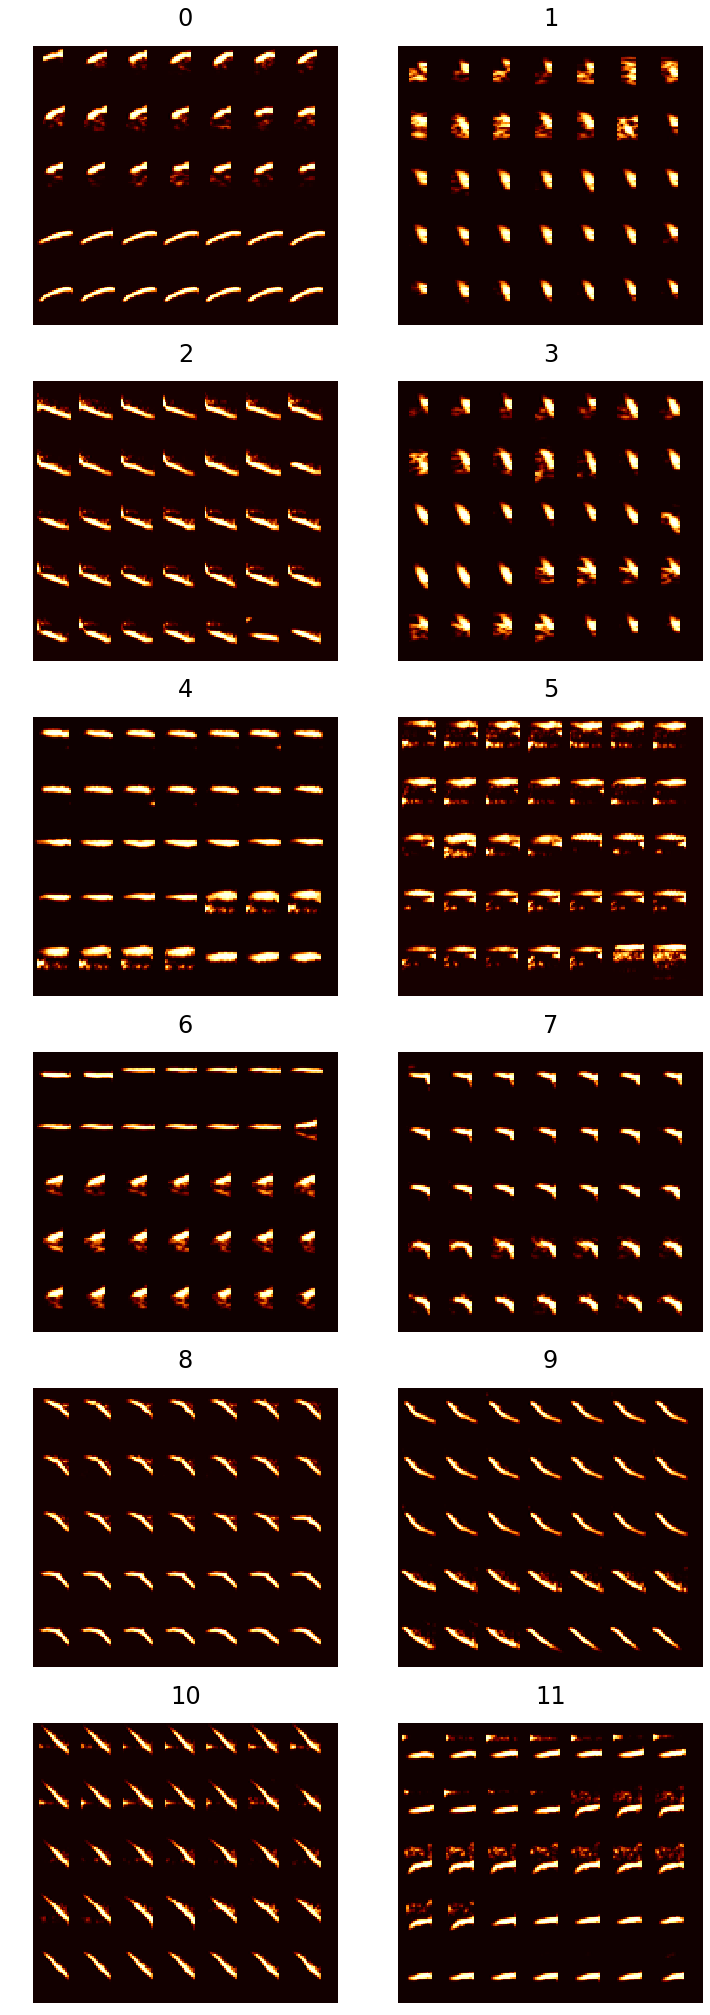

In [70]:
zm = 6
ncols=2
nrows=6
fig, axs = plt.subplots(nrows=nrows, ncols =ncols, figsize= (ncols*zm, nrows*zm))
for li, label in enumerate(unique_clusters):
    ax = axs.flatten()[li]
    draw_spec_set(np.array(specs)[clusterer.labels_ == label], zoom=1, maxrows=5, colsize=5, ax=ax)
    ax.set_title(label, fontsize=24)
for li in range(li, len(unique_clusters)+1):
    ax = axs.flatten()[li]
    ax.axis('off')
plt.show();